In [3]:
from obspy import read
from obspy.core import UTCDateTime
import wave
from obspy import signal
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift
from ipywidgets import widgets
import soundfile as sf
import sounddevice as sd
from IPython.display import Audio
import numpy as np

# Packages for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import offsetbox
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

%matplotlib inline
data_url = 'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T20:10:00.000015.mseed'
localFileName = '/Users/aidanjohnson/Downloads/hydrophone'
# data_url = 'http://service.iris.edu/irisws/timeseries/1/query?net=OO&sta=AXBA1&cha=HDH&start=2015-04-25T17:45:00&end=2015-04-25T17:55:00&demean=true&output=miniseed&loc=--'
# localFileName = 'AXBA1.OO..HDH.2015.115.17.45.00.000-2015.115.17.55.00.000.rm.miniseed'

You can download directly from OOI in the program via the url or to speed up development download the file and place it in the same directory as this notebook and then read the local file.

In [5]:
loadFromOOI=False

if loadFromOOI==True :
    stream = read(data_url)
else:
    stream = read(localFileName)  # Read Previoulsy Download local file for speed

# print some stats about this signal
stream

1 Trace(s) in Stream:
OO.HYVM2..YDH | 2017-08-21T00:02:42.437000Z - 2017-08-21T00:03:11.686984Z | 64000.0 Hz, 1872000 samples

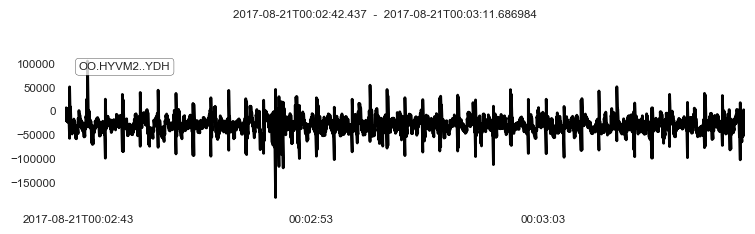

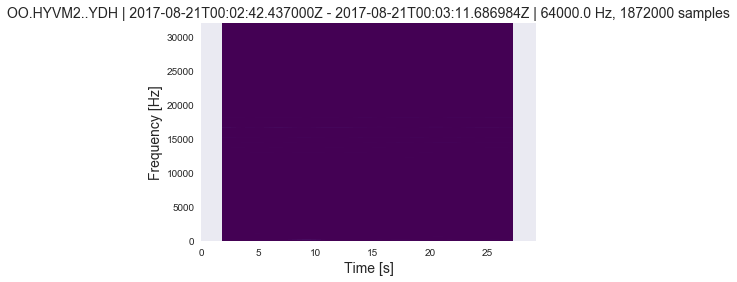

[None]

In [3]:
#Documentation about the obspy library is here https://docs.obspy.org/contents.html
# and list of things you can do with a stream now that its loaded is here
#https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html

#plot the entire 5 minute clip
stream.plot()
stream.spectrogram()

1 Trace(s) in Stream:
OO.HYVM2..YDH | 2017-08-21T00:02:42.437000Z - 2017-08-21T00:03:00.000000Z | 64000.0 Hz, 1124033 samples


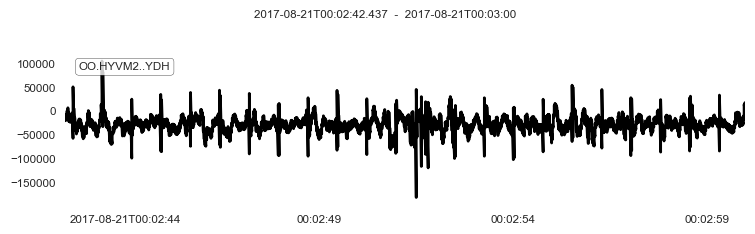

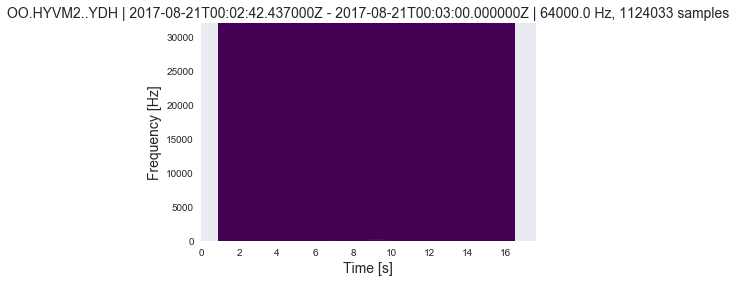

In [6]:
#zoom in and look at just an arbitrary number of seconds

dur = 18
dt = UTCDateTime("2017-08-21T00:02:42")
st = stream.slice(dt, dt + dur)
print(st)  
st.plot()

st[0].spectrogram()

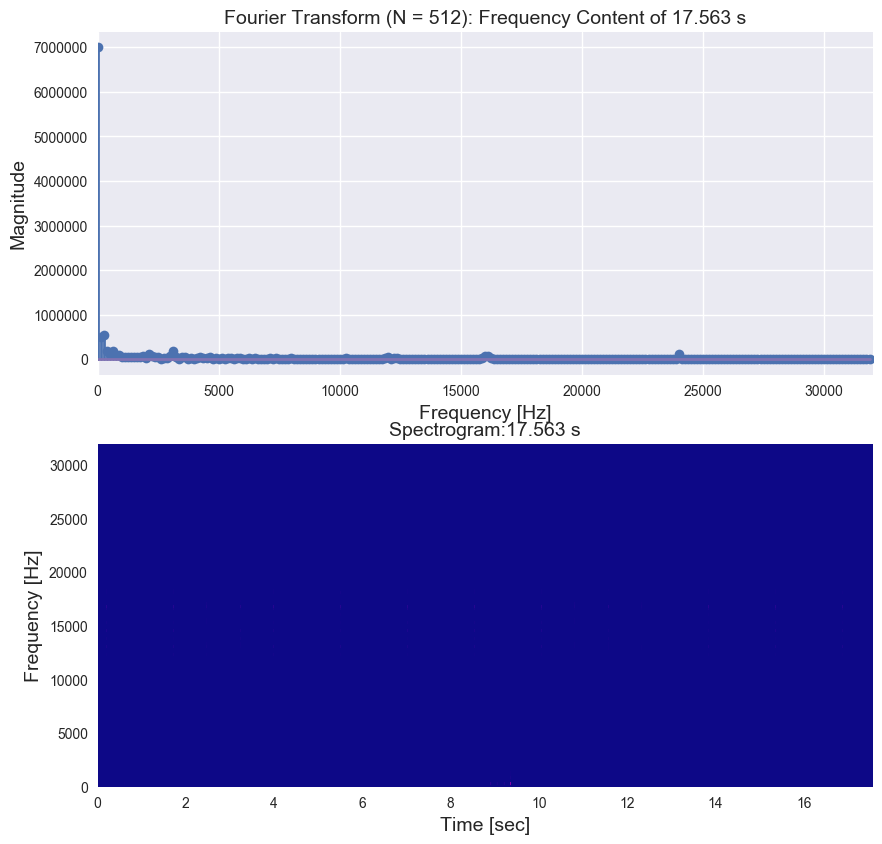

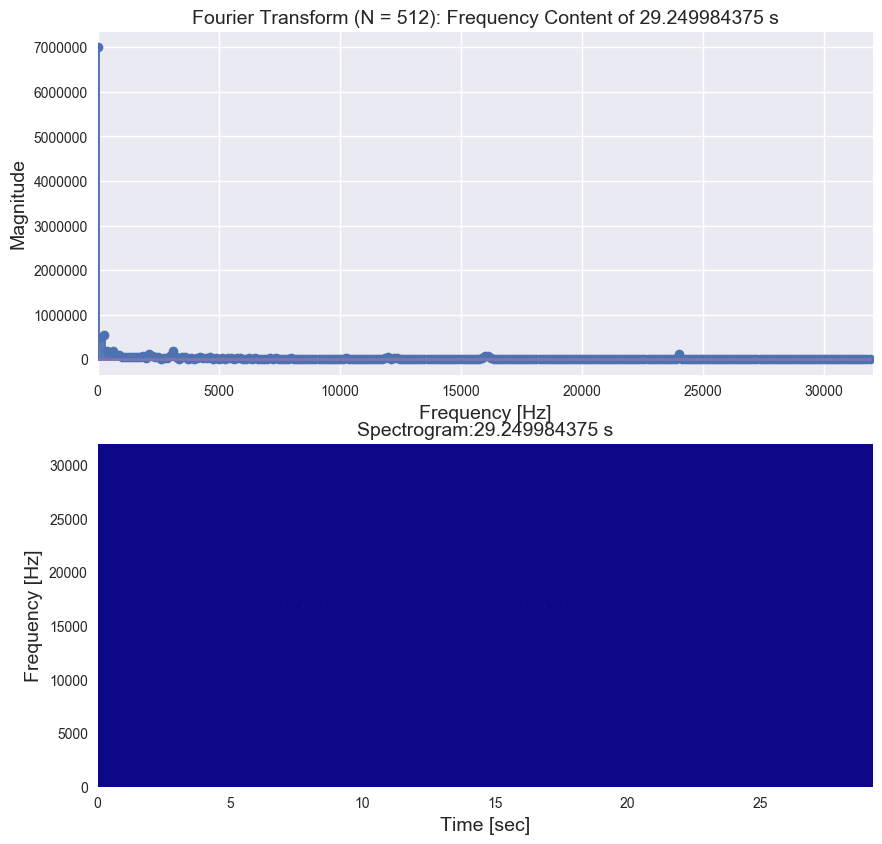

In [7]:
def getSamplingFreq(s):
    string = str(s).split(" ")
    fs = 0;
    for i in range(0, len(string) - 1) :
        char = string[i] 
        count = 1
        if (char == "|"):
            count = count + 1
        if (count == 2):
            fs = string[i + 1]
    return float(fs)

def plotFFT(s):
    y = s[0].copy()
    length = len(s[0])
    N = 512
    Fs = getSamplingFreq(s)
    Y = fftshift(fft(y, N))
    f = fftshift(fftfreq(N, 1/Fs))
    Y = np.abs(np.transpose(Y))
    fig = plt.figure(figsize=(10, 10), dpi=100)
    plt.subplot(2,1,1)
    plt.xlim(0,Fs/2)
    #plt.semilogy(f,Y)
    plt.stem(f,Y)
    plt.title("Fourier Transform (N = " + str(N) + "): Frequency Content of " + str((length-1)/Fs) +  " s")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.subplot(2,1,2)
    f, t, Sxx = signal.spectrogram(np.transpose(y), Fs)
    plt.pcolormesh(t, f, Sxx, cmap='plasma')
    plt.title("Spectrogram:" + str((length-1)/Fs) +  " s")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

st_filt = st.filter('highpass', freq=2.0)
plotFFT(st_filt)
stream_filt = stream.filter('highpass', freq=2.0)
plotFFT(stream_filt)

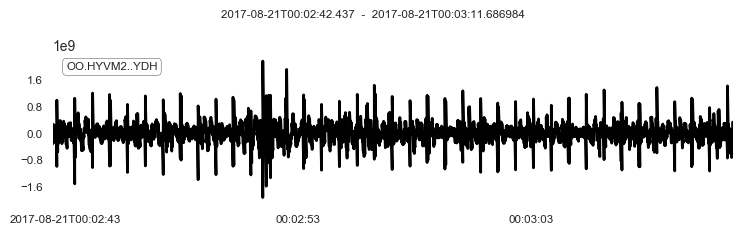

In [8]:
#write it to an audio file that can it can be played in like Audacity
#lets convert it to something easy to play on a PC

trace = stream[0].copy()
trace.filter('highpass', freq=2.0)

#convert to full scale and then make 32 bit

trace.normalize()
trace.data = (trace.data * (2**31-1)).astype('int32')
trace.plot()

def getSamplingFreq(s):
    string = str(s).split(" ")
    fs = 0;
    for i in range(0, len(string) - 1) :
        char = string[i] 
        count = 1
        if (char == "|"):
            count = count + 1
        if (count == 2):
            fs = string[i + 1]
    return float(fs)

Fs = getSamplingFreq(trace)
samplerate = 4*Fs;
trace.write('test.wav', format='WAV', framerate=samplerate)

# samples, samplerate = sf.read('test.wav')
# sd.play(samples, samplerate)
# samples, samplerate = sf.read('test.wav')
# Audio(data=samples, rate=samplerate)

sd.play(trace, samplerate)
Audio(data=stream, rate=samplerate)

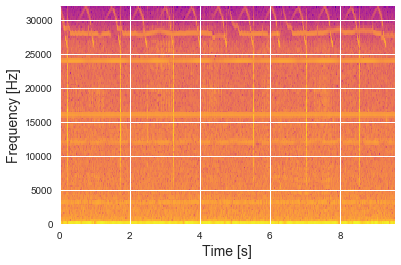

<function __main__.spec>

In [6]:
def spec(Num):
    dt = UTCDateTime("2017-08-21T00:02:42")
    st = stream.slice(dt + Num, dt + Num + 10)
    
    #x=np.array([row[Number] for row in stream])

    plt.specgram(st[0],Fs=64000,noverlap=5, cmap='plasma')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.show()
    
widgets.interact(spec, Num=widgets.IntSlider(min=0,max=5,value=0,step =1,continuous_update=False))
